#### AlexNet Demo
In this notebook we will take a look at a pretrained [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) model.

From [pytorch.org](https://pytorch.org/hub/pytorch_vision_alexnet/):

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The original paper’s primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) during training.

>Note: The pytorch implementation differs a bit from the architecture in the original paper. You can see some amusing discussion on this discrepancy [here](https://github.com/pytorch/vision/pull/463#issuecomment-379214941).


In [69]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from PIL import Image
from torchvision import transforms
import urllib
import torch.nn as nn
from torchinfo import summary

A pretrained version of the AlexNet model can be downloaded from pytorch.org

In [32]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in C:\Users\Adam/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Adam\miniforge3\envs\DESIGN-6197-4197-HW2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adam\miniforge3\envs\DESIGN-6197-4197-HW2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

(np.float64(-0.5), np.float64(1545.5), np.float64(1212.5), np.float64(-0.5))

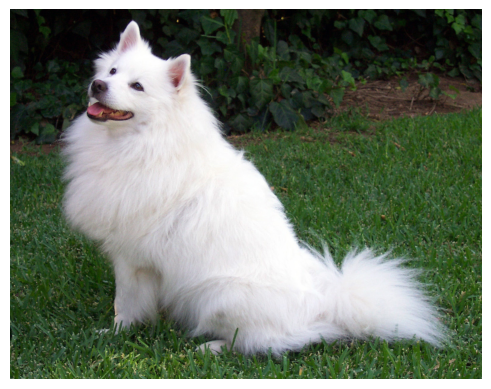

In [33]:
# Download an example image from the pytorch website
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)
plt.imshow(input_image)
plt.axis('off')

Let's look quickly at the shape of this input image.

In [34]:
check_values = transforms.ToTensor()(input_image)
print(f"The shape of our input image is {check_values.shape}")
flatten = rearrange(check_values, 'c h w -> c (h w)')
min_val = torch.min(flatten, dim=1).values
max_val = torch.max(flatten, dim=1).values
print(f"The minimum values per channel are: {min_val} and the maximum values per channel are {max_val}")

The shape of our input image is torch.Size([3, 1213, 1546])
The minimum values per channel are: tensor([0., 0., 0.]) and the maximum values per channel are tensor([1., 1., 1.])


Before we make a prediction on our image, we need to preprocess it. Our input image needs to match the size that AlexNet expects. In this case this means our image needs to be 224 pixels x 224 pixels with 3 color channels. We will also normalize the values using the mean and std of the training set. This is provided by 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


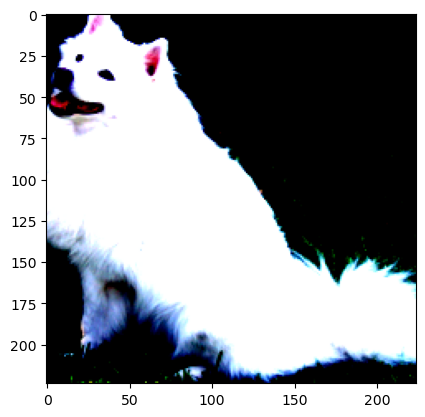

In [35]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))

<BarContainer object of 1000 artists>

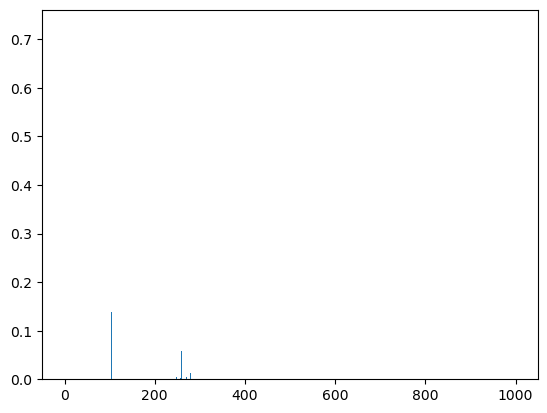

In [36]:


input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
plt.bar(range(1000), probabilities.detach().cpu())

In [37]:
label_url, label_filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
try: 
    urllib.URLopener().retrieve(label_url, label_filename)
except: 
    urllib.request.urlretrieve(label_url, label_filename)

In [38]:
# Read the categories
with open(label_filename, "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.724633514881134
wallaby 0.13920049369335175
Pomeranian 0.05877942219376564
Angora 0.022814644500613213
Arctic fox 0.012455731630325317


In [39]:
print(model.features[0].weight.shape)

torch.Size([64, 3, 11, 11])


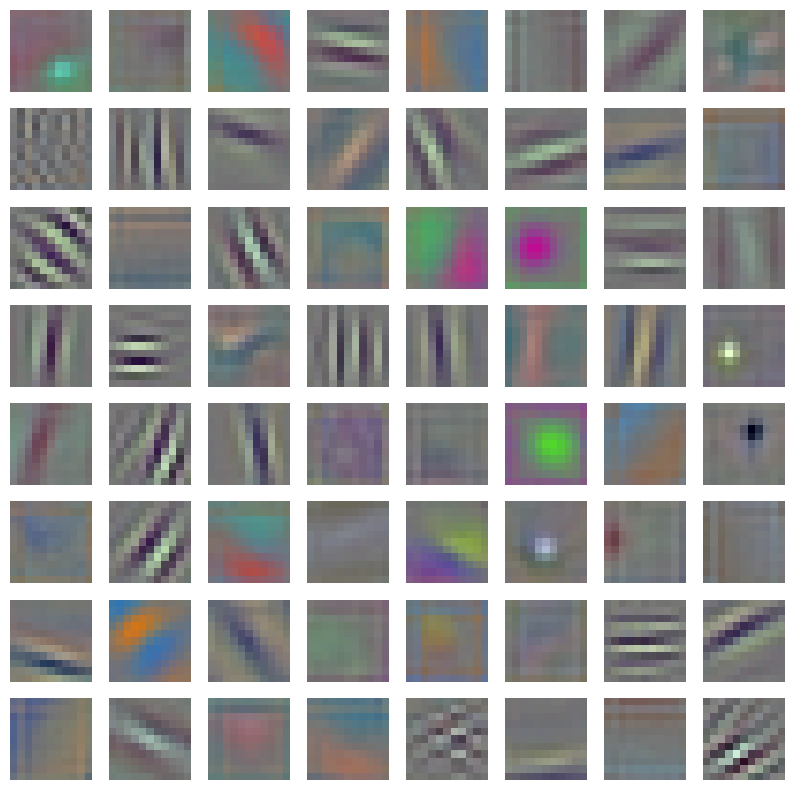

In [40]:
kernels = model.features[0].weight.detach().cpu()
kernels = kernels - kernels.min() 
kernels = kernels / kernels.max()

fig, axarr = plt.subplots(8,8)
fig.set_size_inches(10,10)

for idx, ax in enumerate(axarr.flatten()):
    ax.axis('off')
    ax.imshow(kernels[idx].permute(1, 2, 0))

In [41]:
kernels_2 = model.features[3].weight.detach().cpu()

print(kernels_2.shape)


torch.Size([192, 64, 5, 5])


In [42]:
kernels_2 = reduce(kernels_2, 'o c h w -> o h w', 'sum')

In [43]:
print(kernels_2.shape)

torch.Size([192, 5, 5])


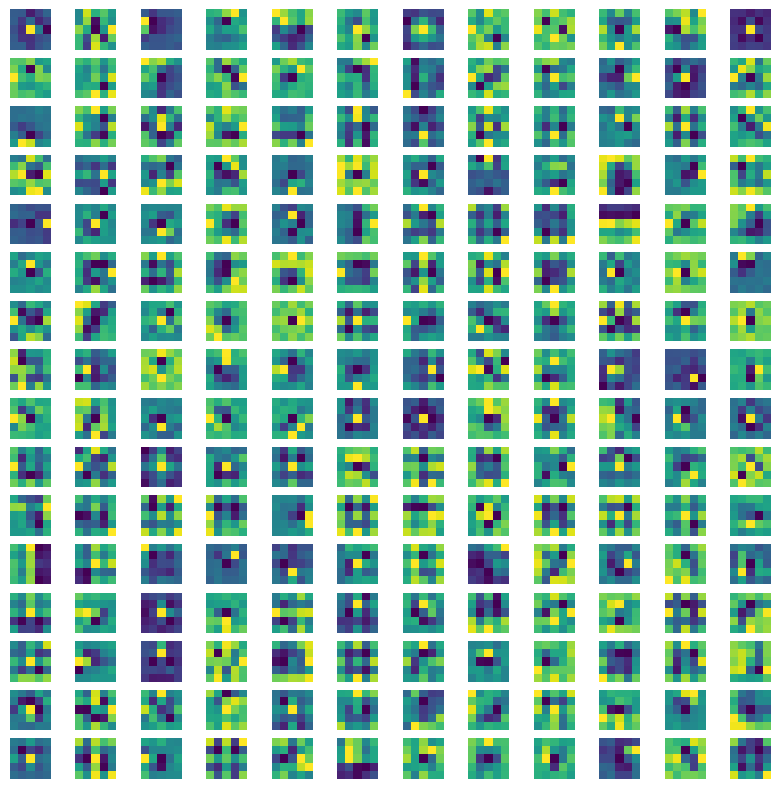

In [44]:
fig_2, axarr_2 = plt.subplots(16,12)
fig_2.set_size_inches(10,10)

for idx, ax in enumerate(axarr_2.flatten()):
    ax.axis('off')
    ax.imshow(kernels_2[idx])

Now we will take a look at what some of these feature maps are doing to the input image!
This code is adapted from [here](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573).

In [78]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [72]:
#Let's take a look at the summary of the model
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

We want to just look at the effect of the convolutional kernels before non-linearity.

In [103]:
#Let's get each layer of the model.

model_layers = []

for layer in model.children():
    if type(layer) == nn.Sequential:
        for l in layer.children():
            model_layers.append(l)
    else:
        model_layers.append(layer)

for layer in model_layers:
    print(layer)


Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
AdaptiveAvgPool2d(output_size=(6, 6))
Dropout(p=0.5, inplace=False)
Linear(in_features=9216, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Linear(in_features=4096, out_features=1000, bias=True)


In [132]:
images = model_layers[0](input_tensor.unsqueeze(0).to('cuda'))

#print feature_maps
print(images.shape)

torch.Size([1, 64, 55, 55])


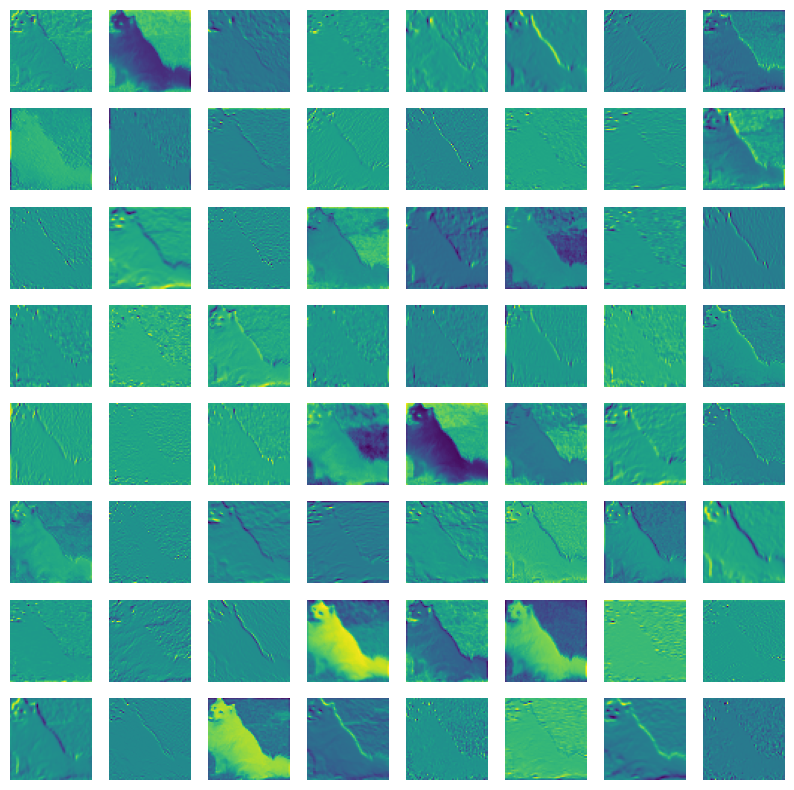

In [95]:
fig_3, axarr_3 = plt.subplots(8,8)
fig_3.set_size_inches(10,10)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

Now let's apply relu and look at the activations again.

In [133]:
images = model_layers[1](images)
print(images.shape)

torch.Size([1, 64, 55, 55])


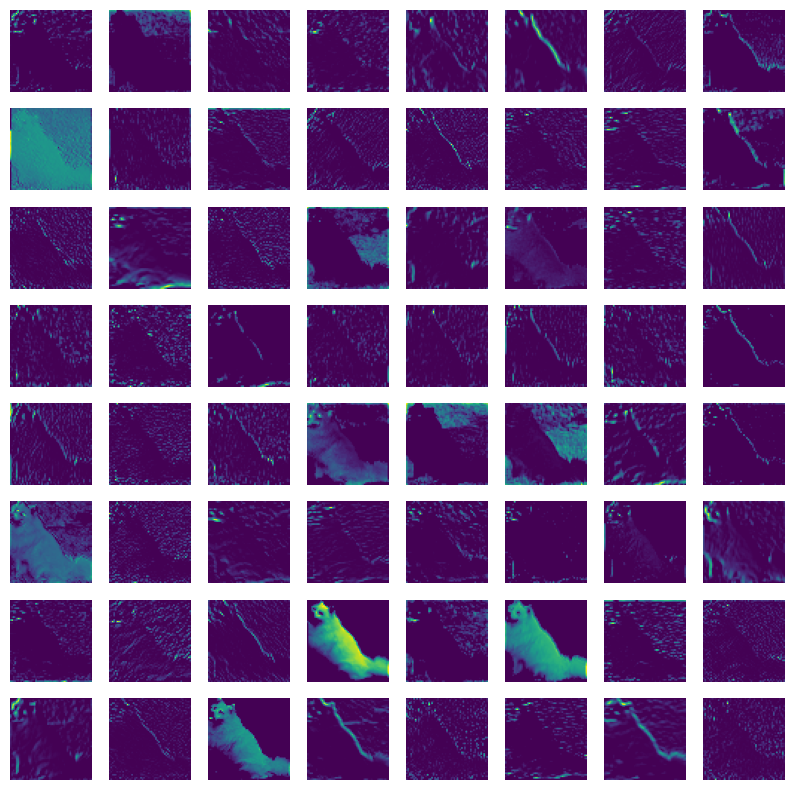

In [97]:
fig_3, axarr_3 = plt.subplots(8,8)
fig_3.set_size_inches(10,10)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

Now we will apply the pooling layer and see the output.

In [134]:
images = model_layers[2](images)
print(images.shape)

torch.Size([1, 64, 27, 27])


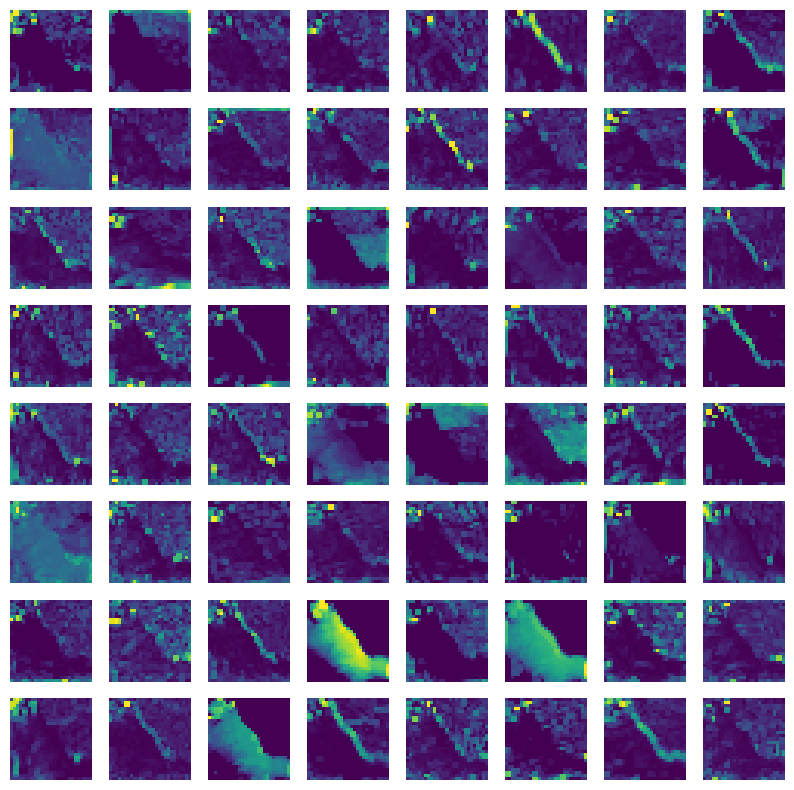

In [99]:
fig_3, axarr_3 = plt.subplots(8,8)
fig_3.set_size_inches(10,10)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [135]:
images = model_layers[3](images)
print(images.shape)

torch.Size([1, 192, 27, 27])


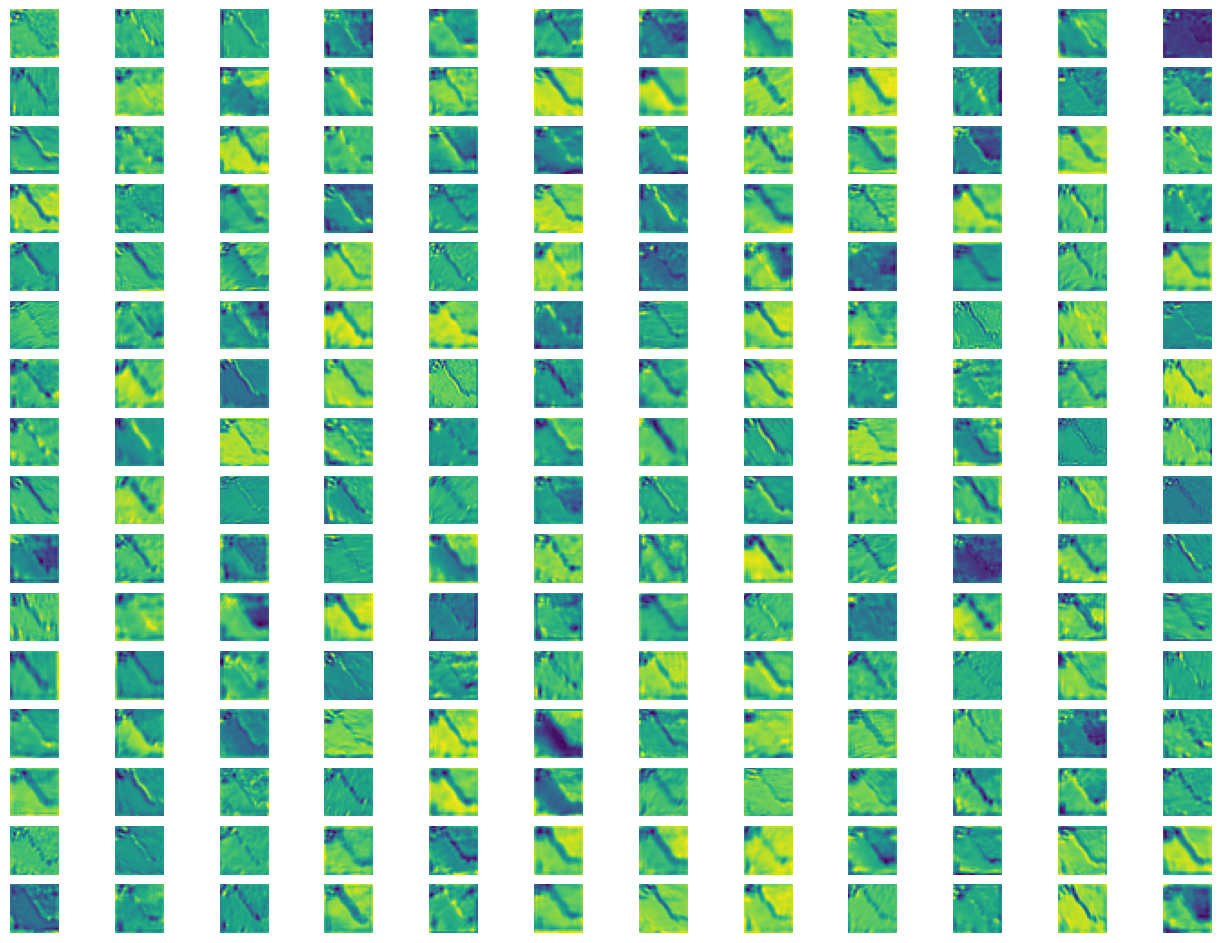

In [101]:
fig_3, axarr_3 = plt.subplots(16,12)
fig_3.set_size_inches(16,12)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [136]:
images = model_layers[4](images)
print(images.shape)

torch.Size([1, 192, 27, 27])


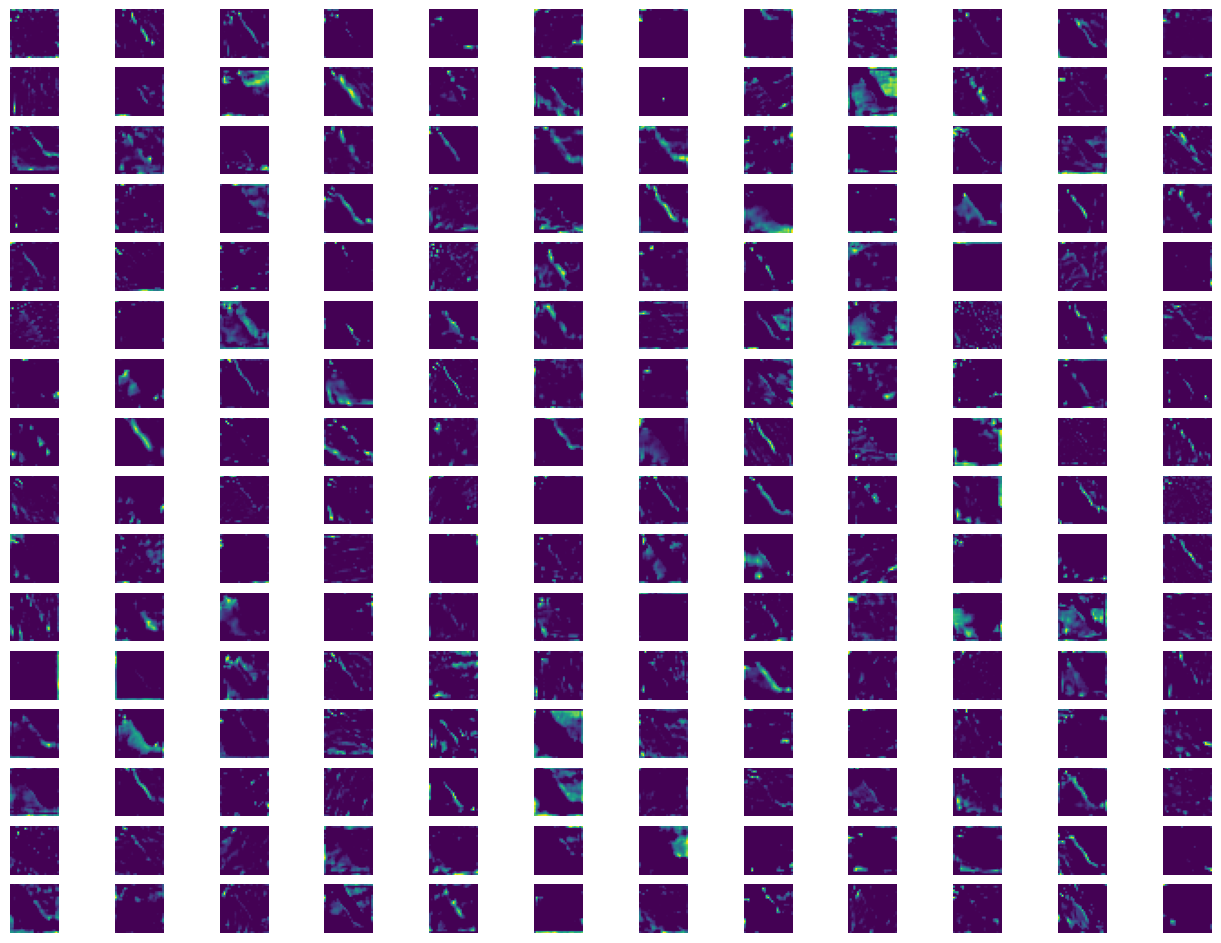

In [107]:
fig_3, axarr_3 = plt.subplots(16,12)
fig_3.set_size_inches(16,12)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [137]:
images = model_layers[5](images)
print(images.shape)

torch.Size([1, 192, 13, 13])


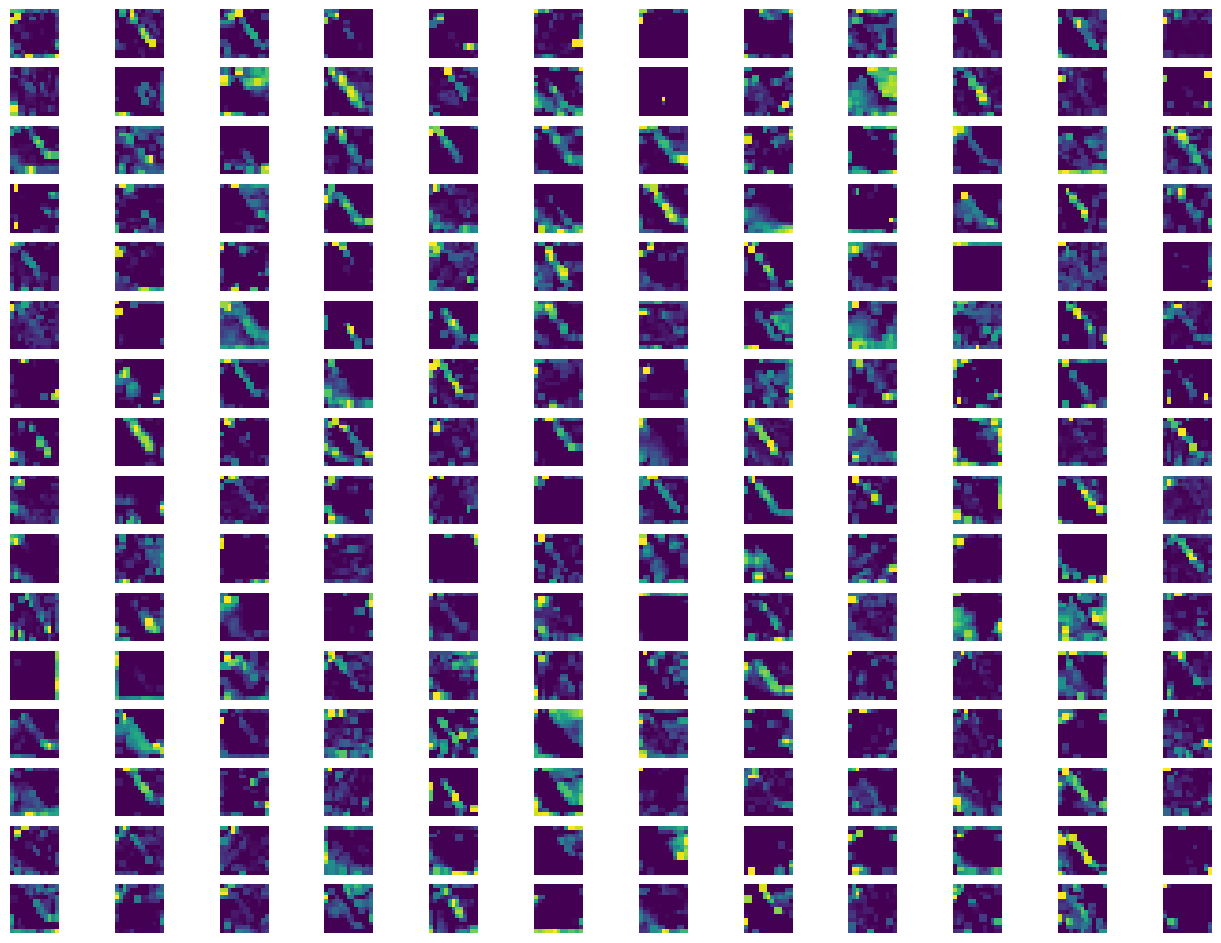

In [109]:
fig_3, axarr_3 = plt.subplots(16,12)
fig_3.set_size_inches(16,12)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [138]:
images = model_layers[6](images)
print(images.shape)

torch.Size([1, 384, 13, 13])


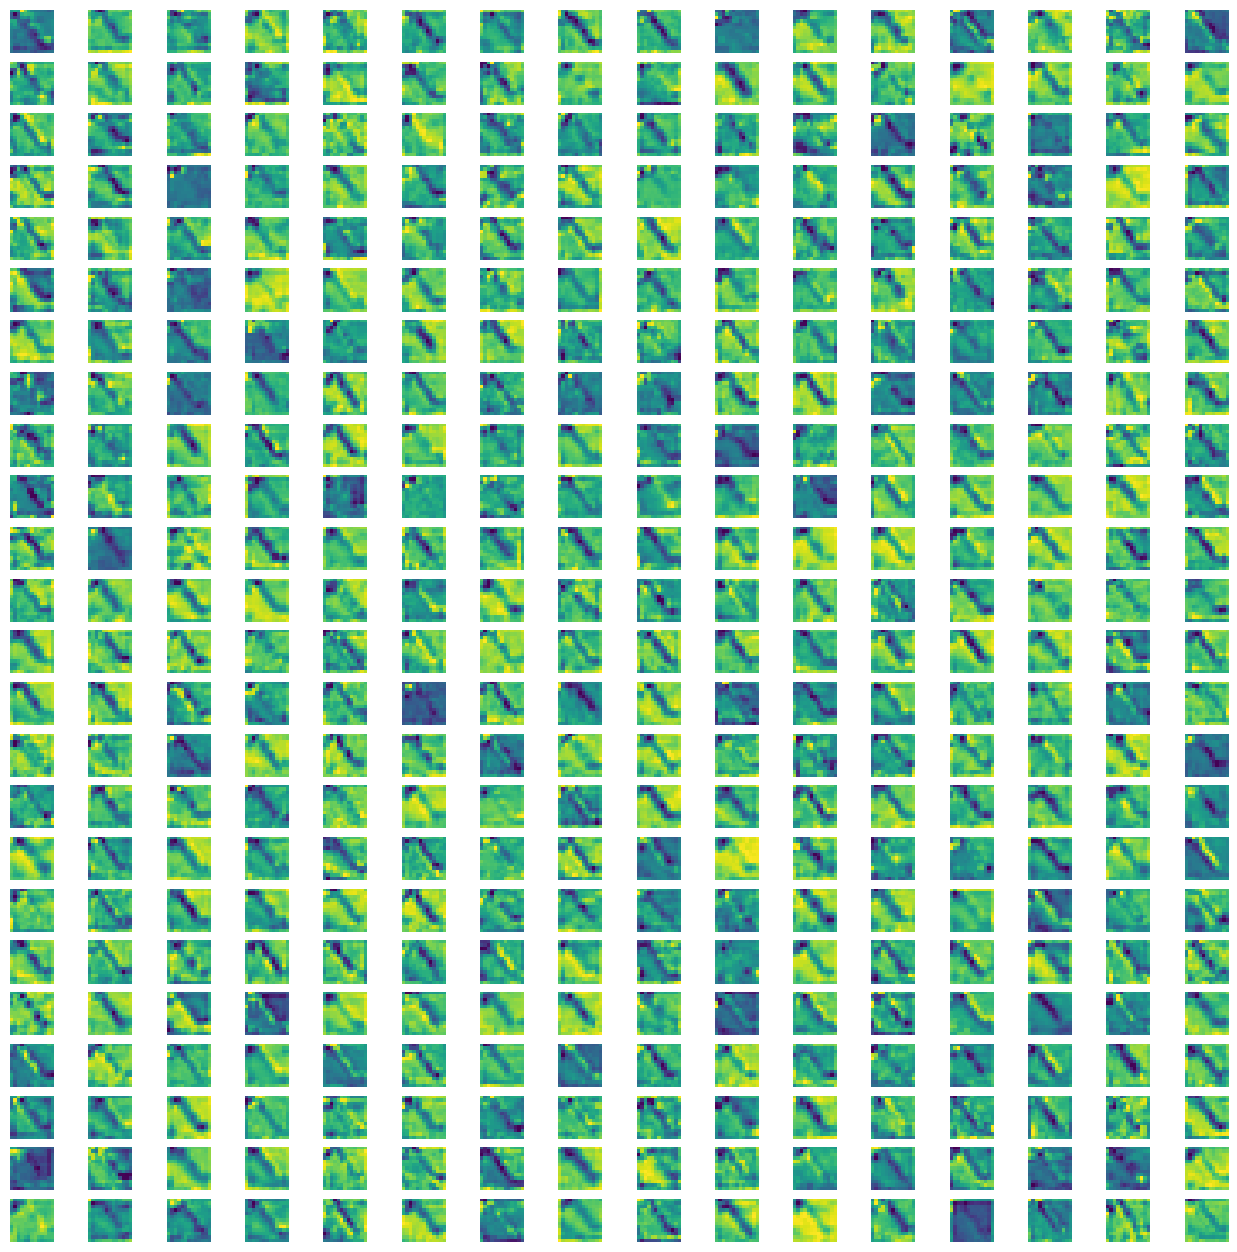

In [139]:
fig_3, axarr_3 = plt.subplots(24,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [140]:
images = model_layers[7](images)
print(images.shape)

torch.Size([1, 384, 13, 13])


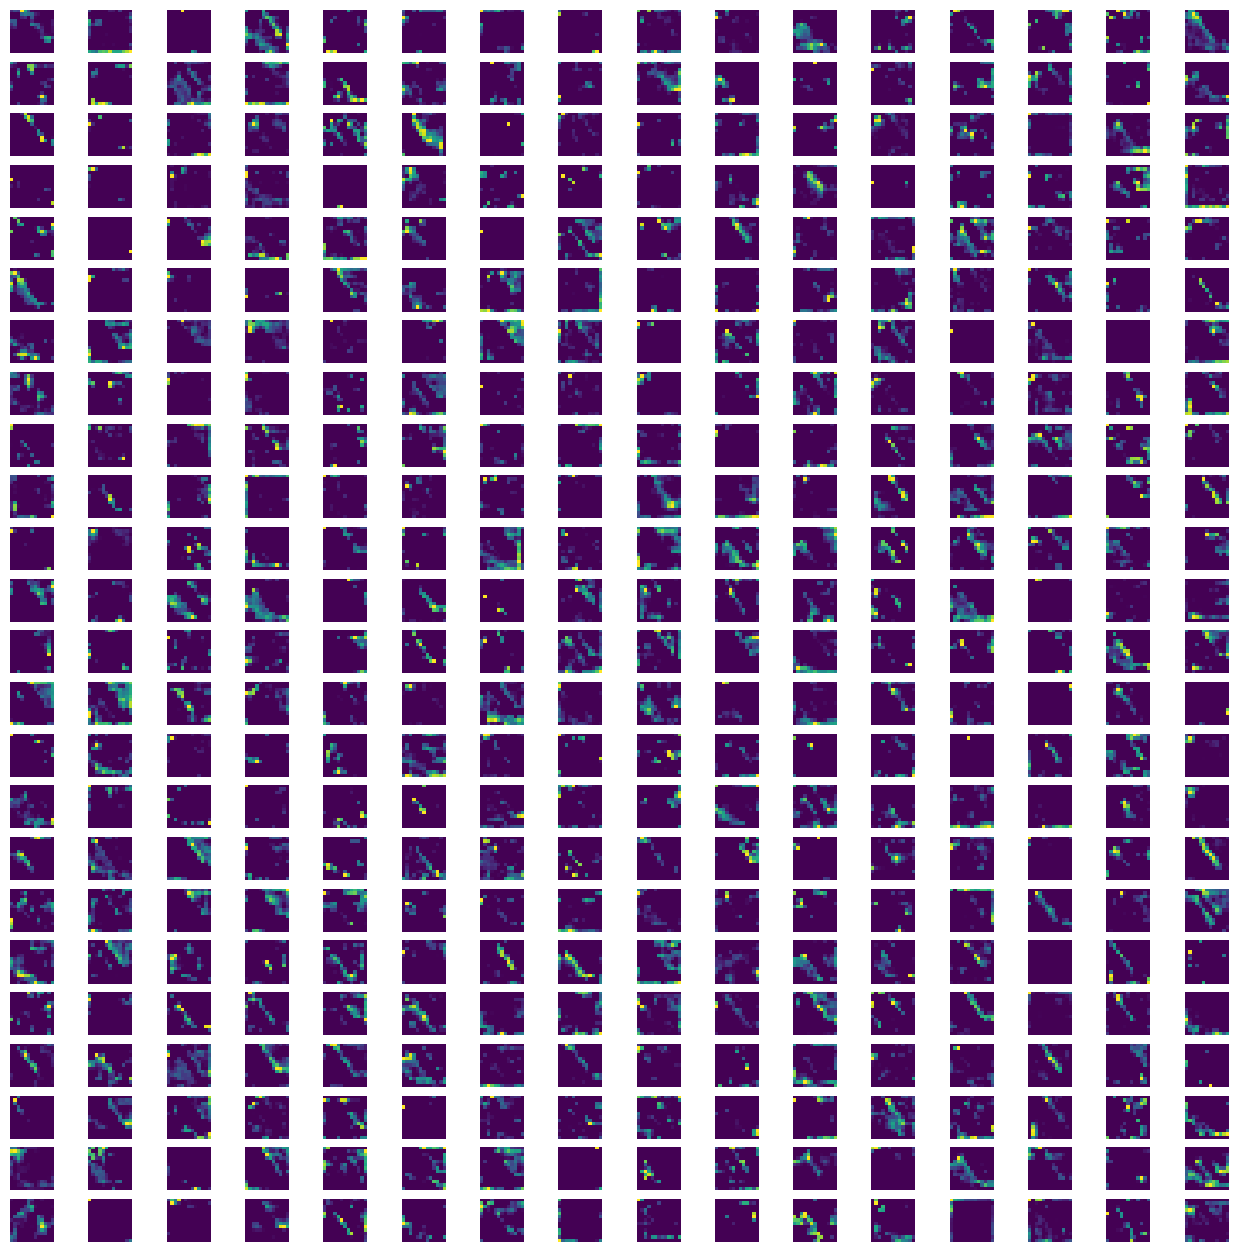

In [115]:
fig_3, axarr_3 = plt.subplots(24,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [141]:
images = model_layers[8](images)
print(images.shape)

torch.Size([1, 256, 13, 13])


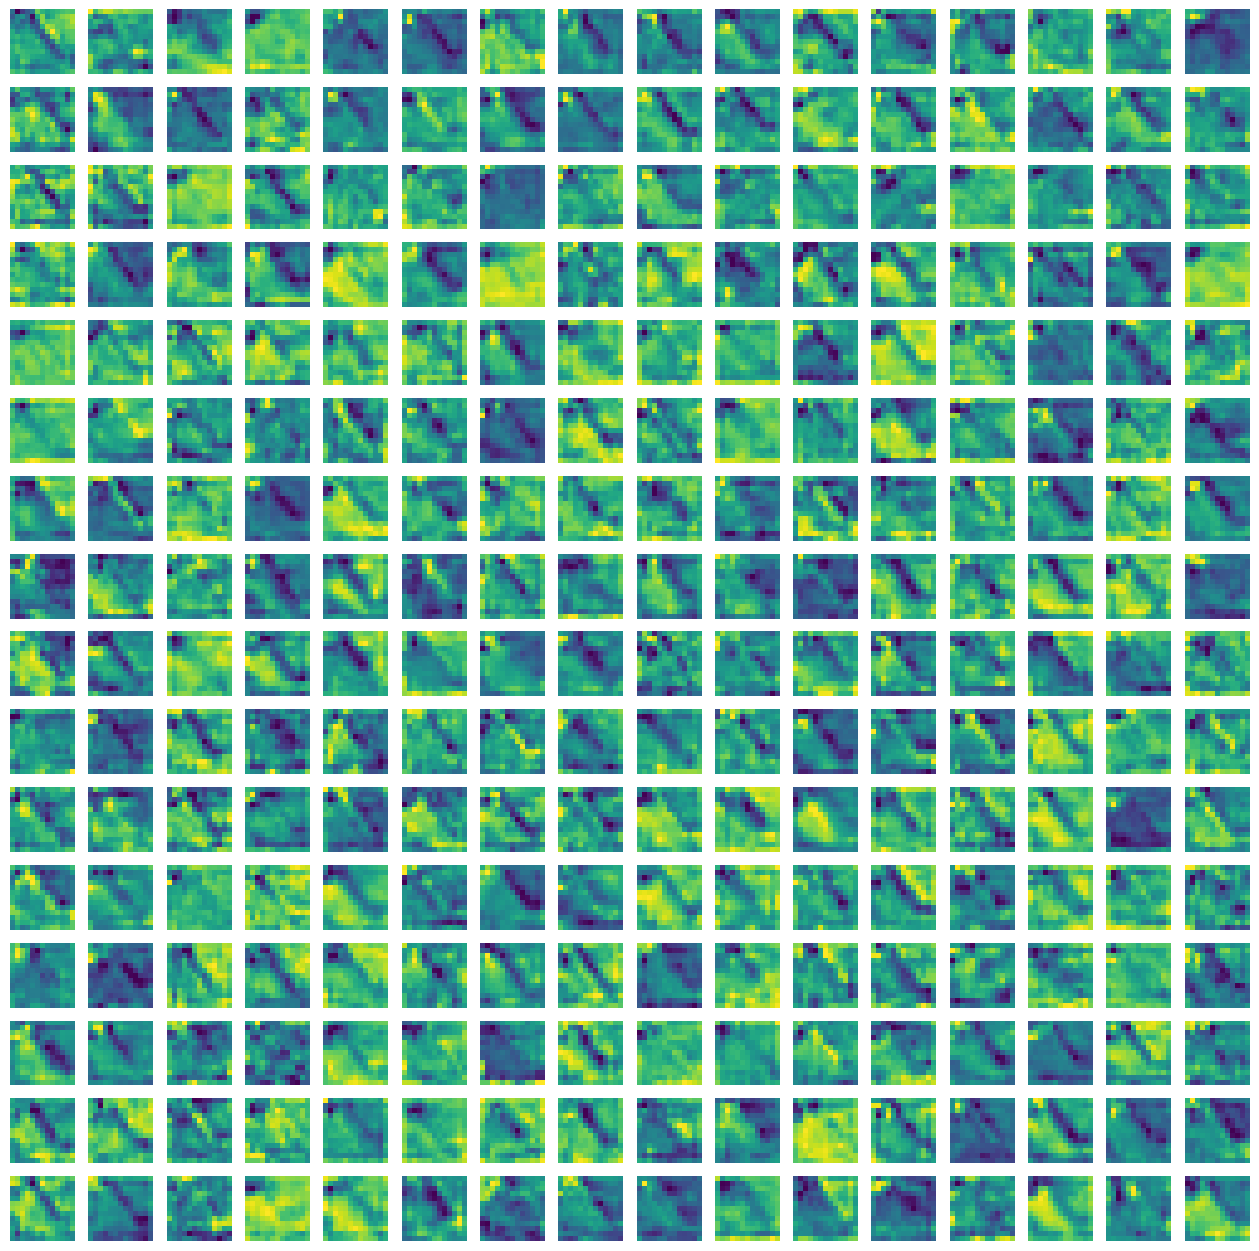

In [117]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [142]:
images = model_layers[9](images)
print(images.shape)

torch.Size([1, 256, 13, 13])


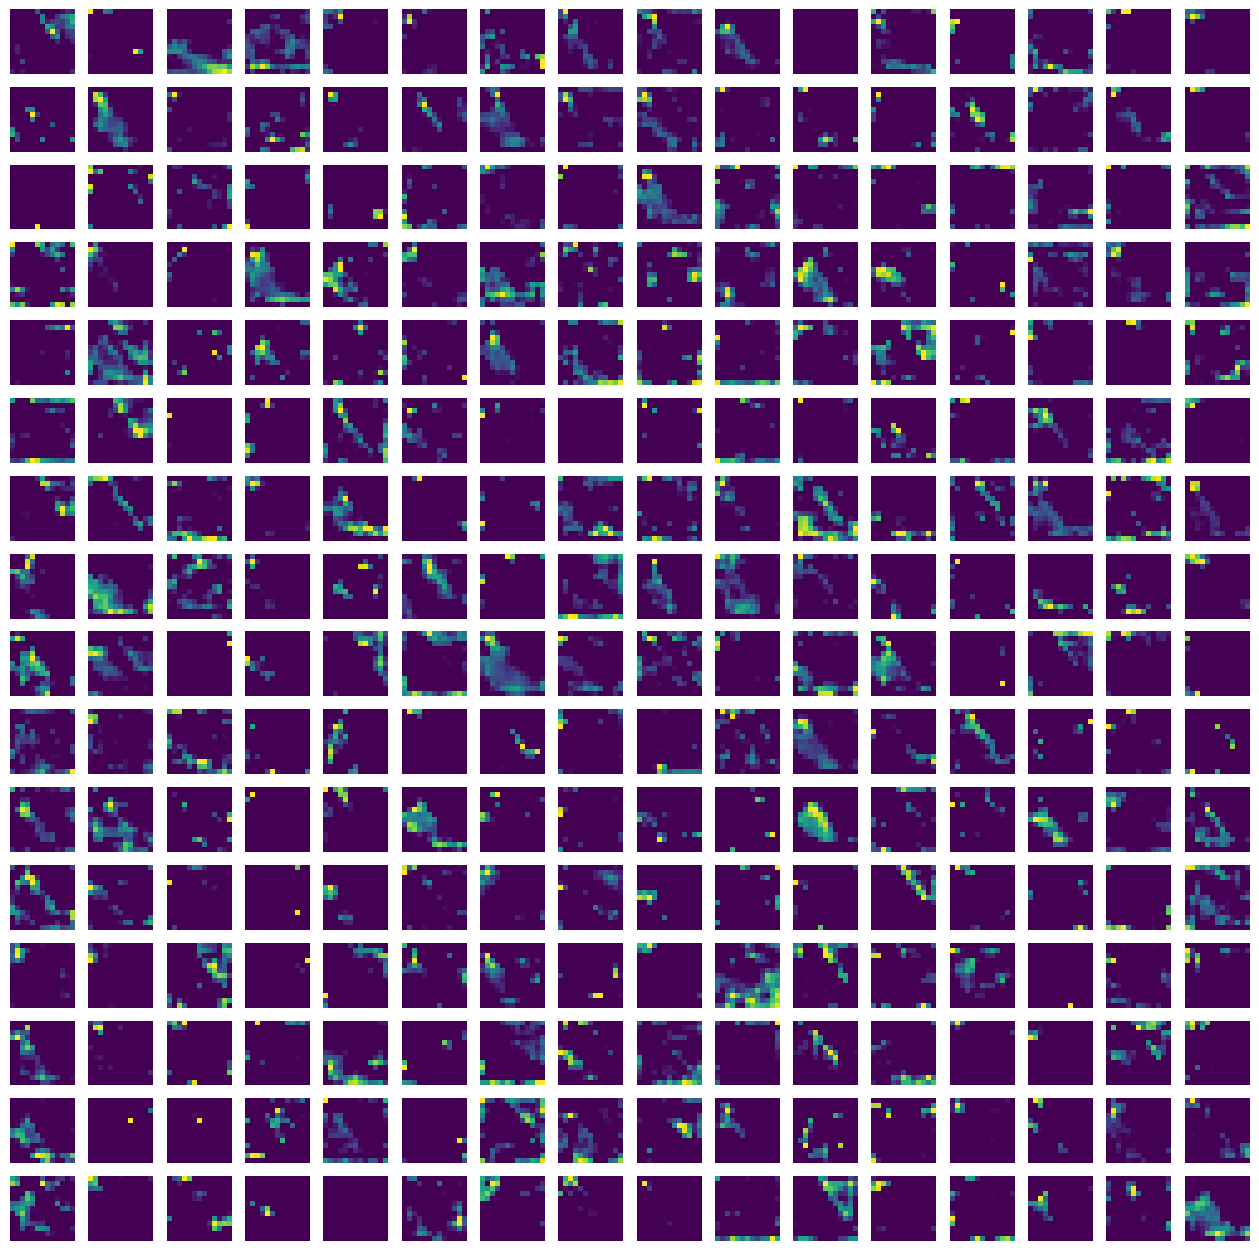

In [119]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [143]:
images = model_layers[10](images)
print(images.shape)

torch.Size([1, 256, 13, 13])


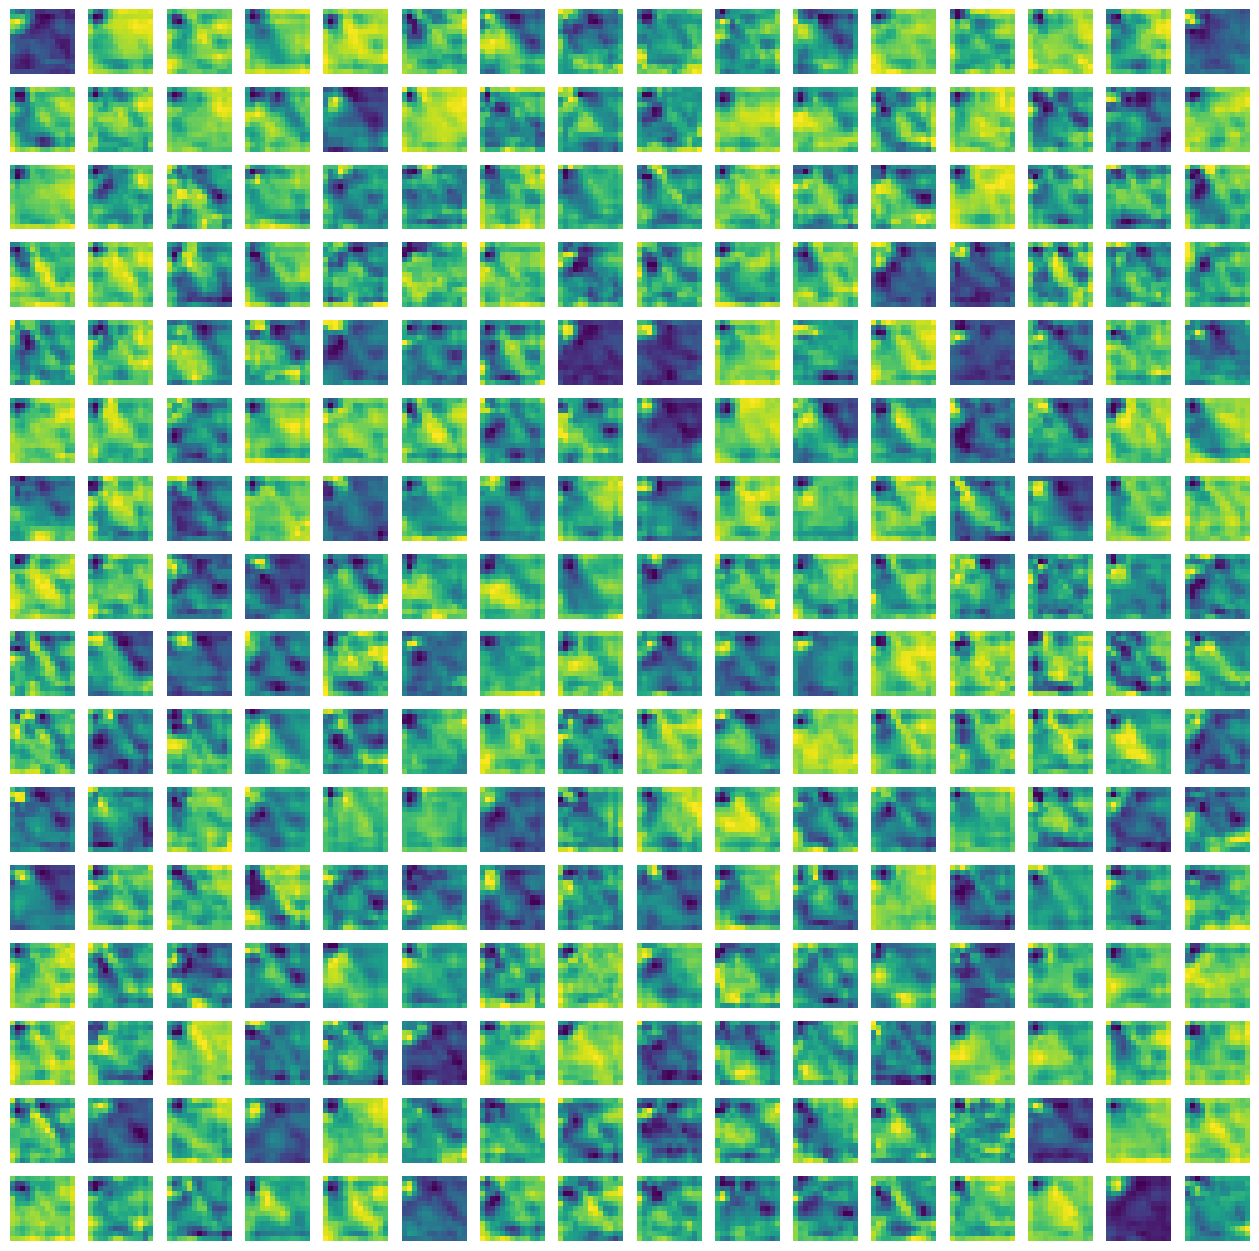

In [121]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [144]:
images = model_layers[11](images)
print(images.shape)

torch.Size([1, 256, 13, 13])


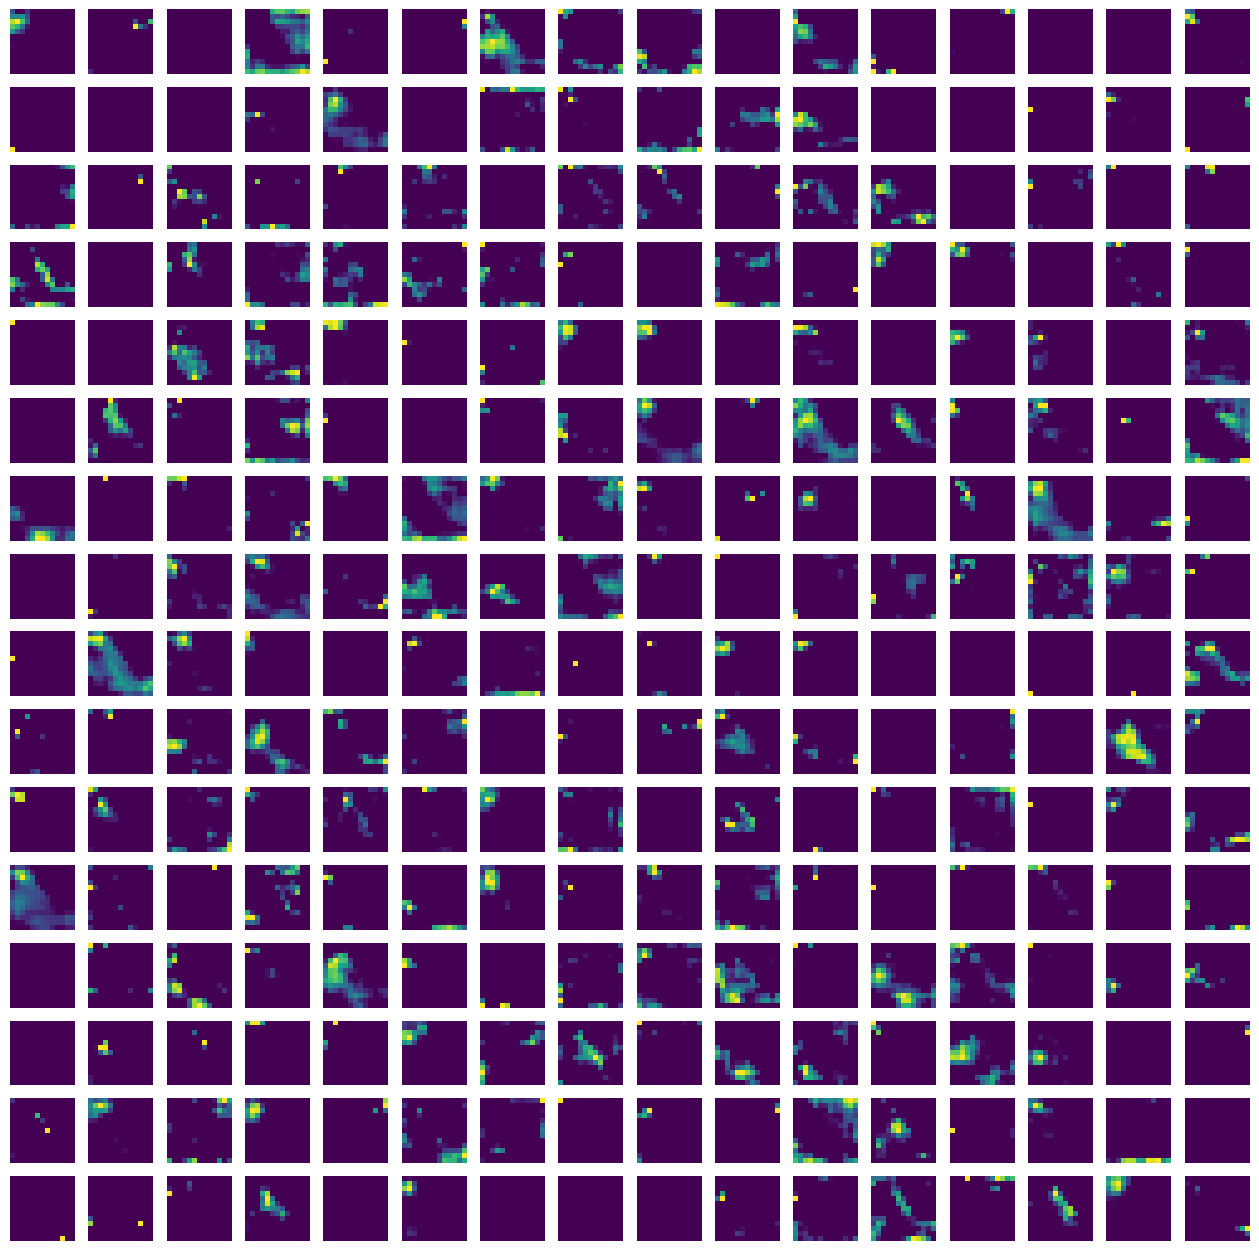

In [123]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [145]:
images = model_layers[12](images)
print(images.shape)

torch.Size([1, 256, 6, 6])


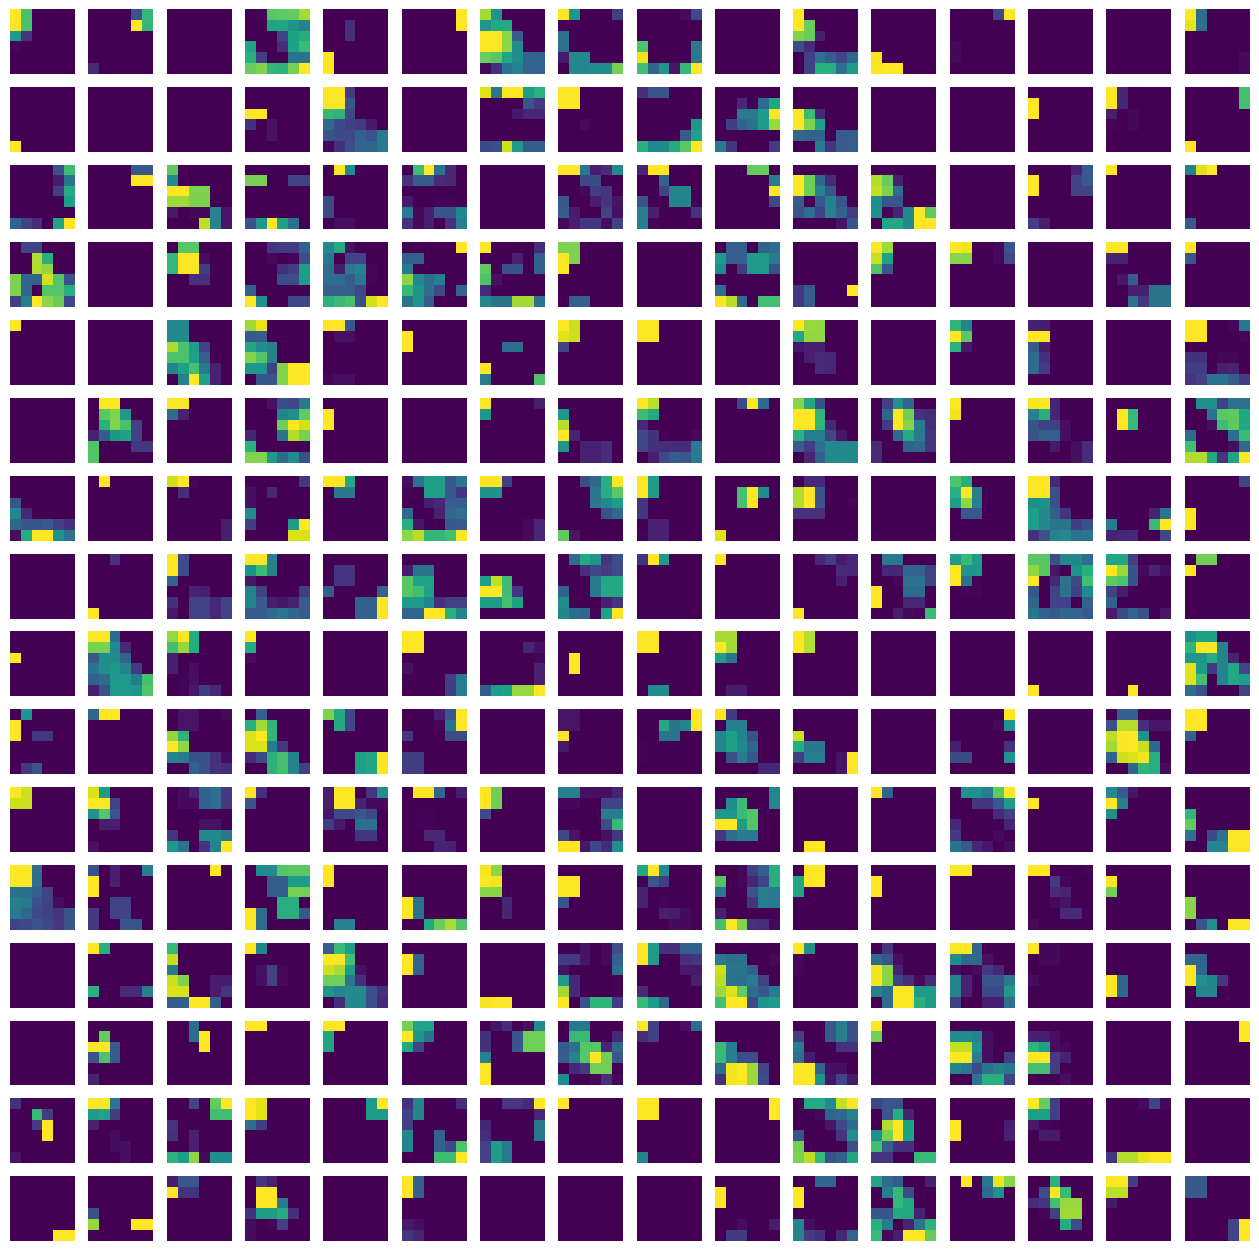

In [125]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [146]:
images = model_layers[13](images)
print(images.shape)

torch.Size([1, 256, 6, 6])


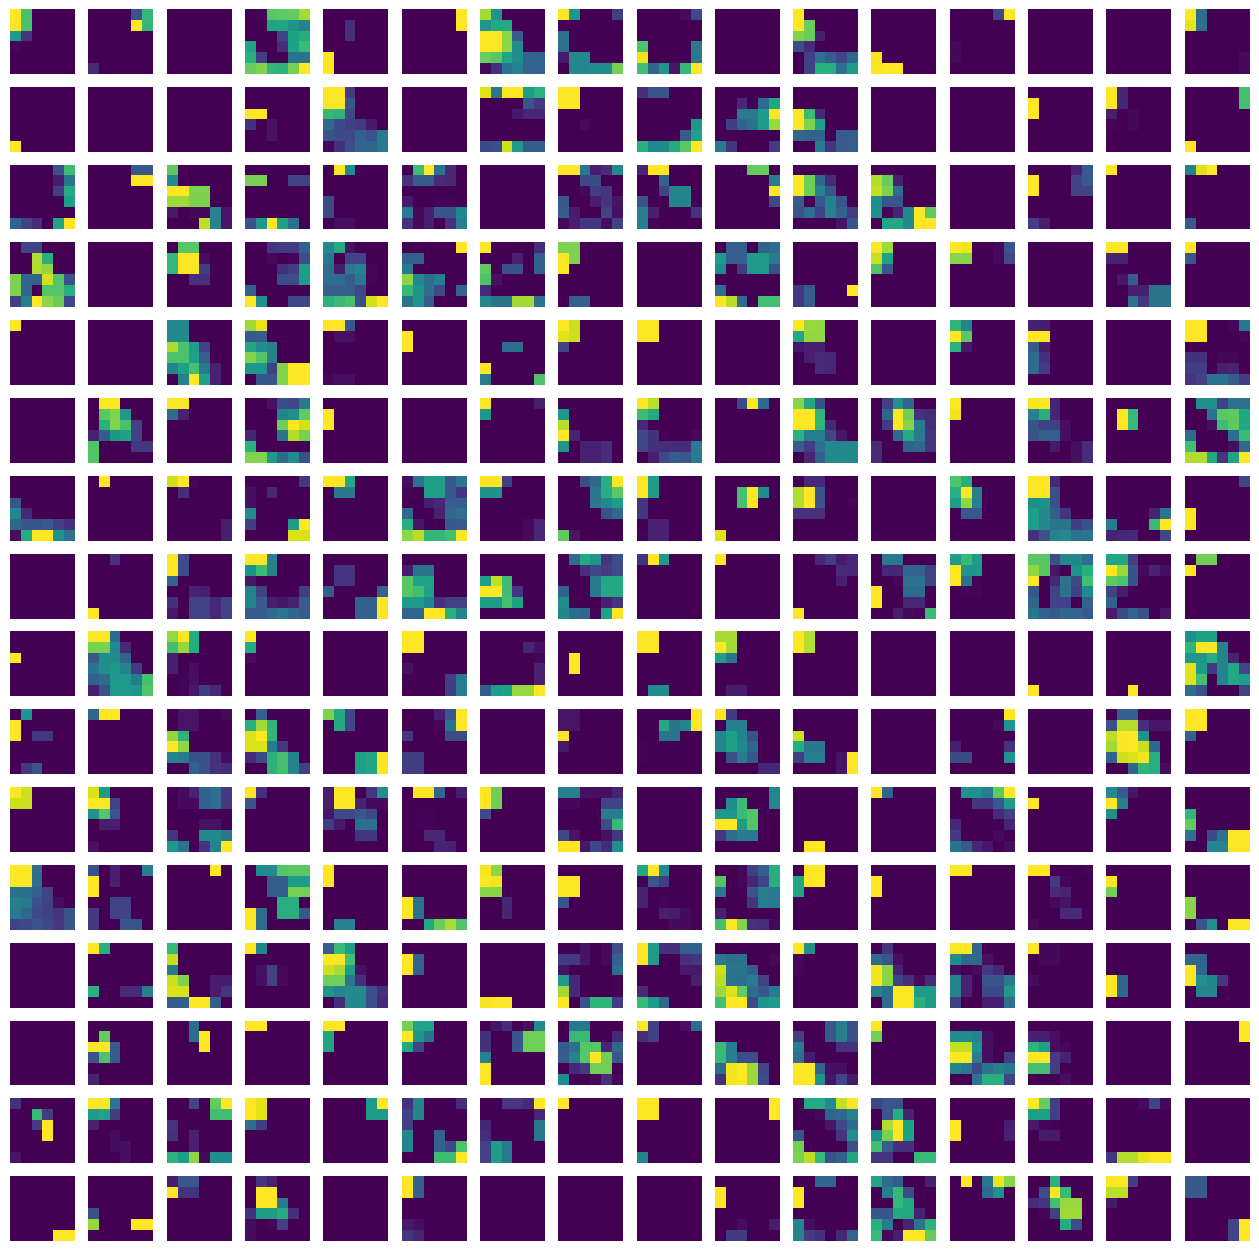

In [147]:
fig_3, axarr_3 = plt.subplots(16,16)
fig_3.set_size_inches(16,16)

for idx, ax in enumerate(axarr_3.flatten()):
    ax.axis('off')
    ax.imshow(images[0][idx].detach().cpu().squeeze())

In [153]:
print(model_layers[13])
print(model_layers[14])
print(model_layers[15])

AdaptiveAvgPool2d(output_size=(6, 6))
Dropout(p=0.5, inplace=False)
Linear(in_features=9216, out_features=4096, bias=True)
